# Apply Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner


**Note:** This script applies a **pretrained flight condition normalization pipeline**
to both **development (training)** and **test** datasets.  
No model training is performed her. The pipeline is loaded and applied unchanged.

In [1]:
from pathlib import Path
import os

import pandas as pd
import matplotlib.pyplot as plt
import joblib

from src.training.opcond_pipelines import EstimationPipeline
from src.helpers.filters import AdaptiveEMA

from experiment_config import (
    DATA_NAME,Q_LOW,Q_HIGH,FAILED_THRESHOLD,ESTIMATION_NAME,
    FILT_NOISE_MEM,FILT_SMOOTH_STRENGTH, FILTER_DATA
)

## Configuration

In [2]:
data_split ='dev'#'test' # 

In [3]:
experiment_dir = Path('experiments')/DATA_NAME
opcond_dir = experiment_dir/'opcond'


## 1. Load dataset

In [4]:
df = pd.read_csv(experiment_dir/f'data_{data_split}.csv',dtype={"Fc": str})

## Load the pipeline

In [5]:
pipe:EstimationPipeline = joblib.load(opcond_dir/"pipeline_best.joblib")
pipe.set_bounds(df,Q_LOW,Q_HIGH)


,oc_pipe,Pipeline(step...tart=False))])
,residual_aggregator,"OperCondResid...PC', 'SmHPC'])"
,hi_transformer,"HealthIndexTr...PC', 'SmHPC'])"
,hs_col,'hs'
,metrics,"['T48', 'SmFan', ...]"
,cycle_col,'cycle'
,q_low,0.01
,q_high,0.99
,corr_thresh,0.6
,range_thresh,0.6
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"


## Apply pipeline

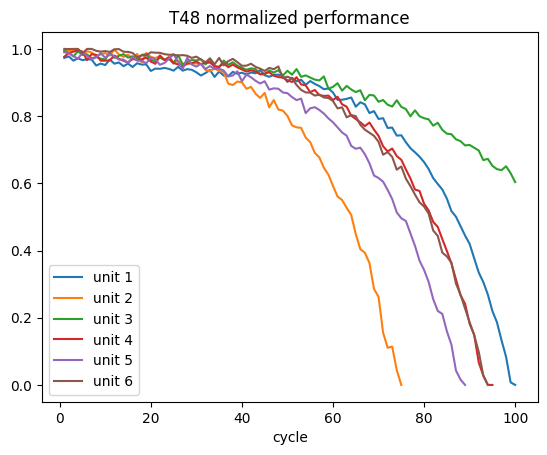

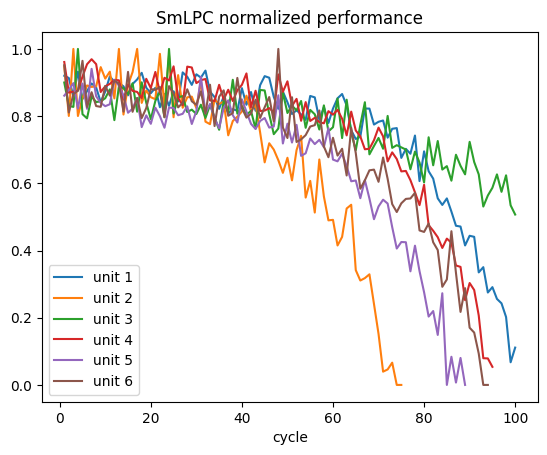

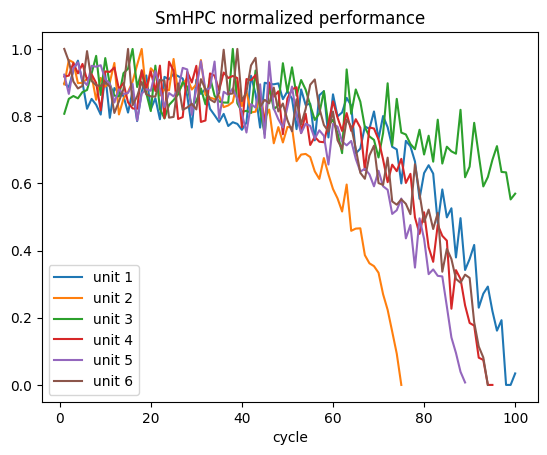

In [6]:
df_hi = pipe.transform(df)
for perf in pipe.get_performances():
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} normalized performance")
    for unit, df_unit in df_hi.groupby("unit"):
        df_unit.plot(
            x="cycle",
            y=perf,
            ax=ax,
            legend=True,
            label=f"unit {int(unit)}",
        )

## Add health index

In [7]:
df_hi = df_hi[['unit']+['cycle']+ pipe.get_performances()]

df_cycle = df.drop_duplicates(subset=["unit","cycle"], keep="last")
df_hi['hs'] = df_cycle['hs'].values 

## Exclude no failed units

In [8]:
if data_split == 'dev':
	valid_units = set()
	for perf in pipe.get_performances():
		failed_units_perf = df_hi.loc[df_hi[perf] < FAILED_THRESHOLD, "unit"].unique().tolist()
		valid_units = valid_units.union(set(failed_units_perf))
else:
    valid_units = set(df_hi["unit"].unique().tolist())

df_hi = df_hi[df_hi['unit'].isin(valid_units)]
print(f"Units: {valid_units}")

Units: {1.0, 2.0, 4.0, 5.0, 6.0}


## Add Causal Filter

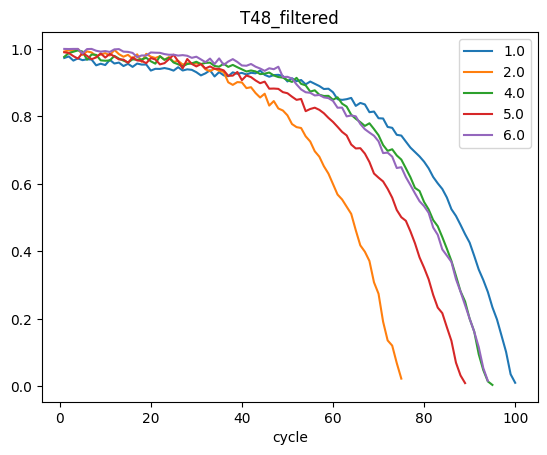

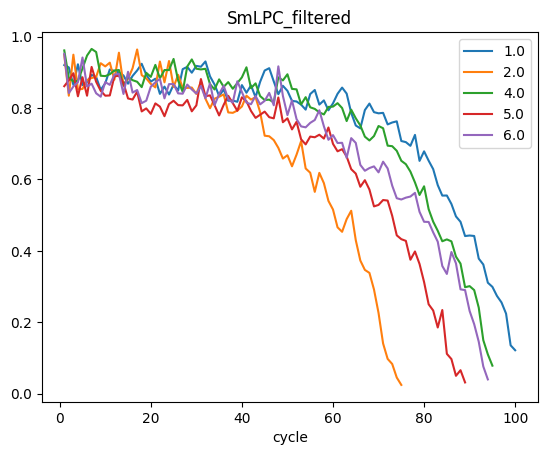

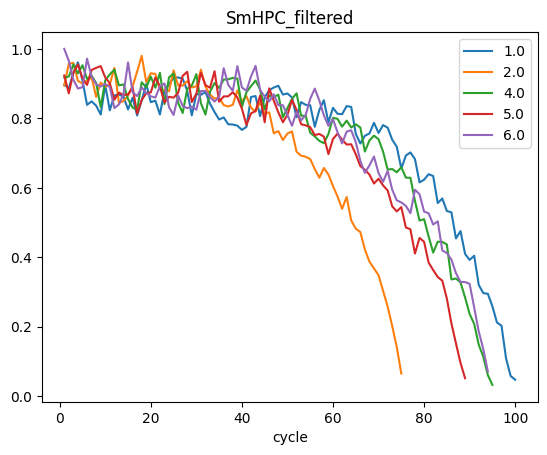

In [9]:
if FILTER_DATA:
    for name in pipe.get_performances():
        for unit, idx in df_hi.groupby("unit").groups.items():
            f = AdaptiveEMA(
                    beta=FILT_NOISE_MEM, 
                    k=FILT_SMOOTH_STRENGTH)
            df_hi.loc[idx, name] = [
                f.step(x) for x in df_hi.loc[idx, name].values
            ]
            
    for name in pipe.get_performances():
        fig, ax = plt.subplots()
        ax.title.set_text(f"{name}_filtered")
        df_hi.set_index("cycle").groupby("unit")[name].plot(legend=True)
        plt.show()

## Save estimation data

In [10]:
estimation_dir  = experiment_dir/ESTIMATION_NAME

os.makedirs(estimation_dir, exist_ok=True)
df_hi.to_csv(estimation_dir/f'data_{data_split}.csv', index=False)